In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Bernoulli, Normal, Categorical, Poisson, Mixture, PointMass, Empirical
from edward.util import Progbar
from tensorflow.contrib import slim

from IPython.display import clear_output

%matplotlib inline

In [2]:
ed.set_seed(42)
sess = ed.get_session()

In [85]:
def sigmoid(x):
    return 1. / (1+ np.exp(-x))

# VAE Gaussian Gaussian

### Build dataset and map into high dim space

In [3]:
def build_toy_dataset(N, train_test_ratio = 0.33):
    pi = np.array([0.5, 0.5])
    mus = np.array([[1, 1], [-1, -1]])
    stds = [[0.1, 0.1], [0.1, 0.1]]
    x = np.zeros((N, 2), dtype=np.float32)
    c = np.zeros((N), dtype=np.int32)
    for n in range(N):
        k = np.argmax(np.random.multinomial(1, pi))
        c[n] = k
        x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))
    
    n_test = int(N*train_test_ratio)

    return x[:n_test], c[:n_test], x[n_test:], c[n_test:]

In [68]:
N = 100000  # number of data points
n_latent = 2
n_input = 50
sigma = 0.5

latent_train, c_train, latent_test, c_test = build_toy_dataset(N)

W = np.random.normal(loc=0.0, scale=1.0, size=(n_latent, n_input))

X_train = np.random.normal(loc=np.dot(latent_train, W), scale=sigma)
X_test = np.random.normal(loc=np.dot(latent_test, W), scale=sigma)

### Visualize latent space and random proj of high space

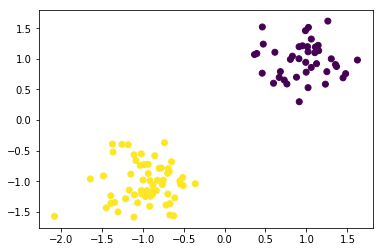

In [69]:
# observe the latent space
plt.scatter(latent_train[:100, 0], latent_train[:100, 1], c=c_train[:100])

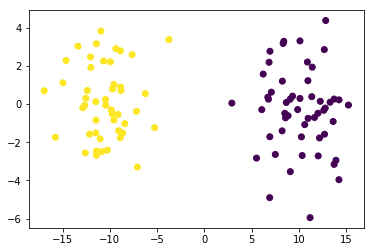

In [70]:
from sklearn.decomposition import PCA
l = PCA(n_components=2).fit_transform(X_test)
plt.scatter(l[:100, 0], l[:100, 1], c=c_test[:100])

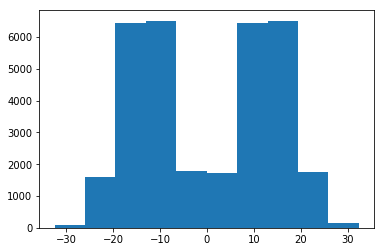

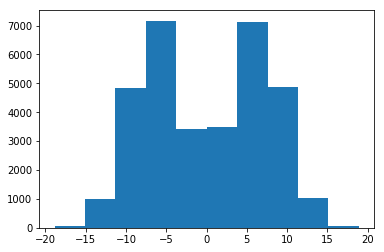

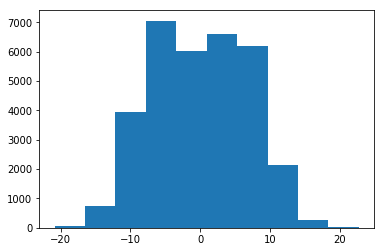

In [71]:
#observe random projections
for i in range(3):
    plt.hist(np.dot(np.random.normal(0, 1, size=(n_input)) , X_train.T))
    plt.show()

## Write the Gaussian VAE model in edward

In [72]:
M = 100  # batch size during training

n_hidden = 10
STD = 0.01 # initialization STD for neural weights

#positive_map = tf.nn.softplus
positive_map = tf.exp

In [73]:
def generative_network(input_z):
    """Generative network to parameterize generative model. It takes
    latent variables as input and outputs the likelihood parameters.

    loc, scale = neural_network(input_z)

    """
    
    net = slim.fully_connected(input_z, n_hidden, 
                               activation_fn=tf.nn.relu, weights_initializer=tf.truncated_normal_initializer(stddev=STD))
    params = slim.fully_connected(net, 2*n_input, 
                                  activation_fn=None, weights_initializer=tf.truncated_normal_initializer(stddev=STD))
    location = params[:, :n_input]
    scale = positive_map(params[:, n_input:])
    return location, scale
    

def inference_network(input_x):
    """Inference network to parameterize variational model. It takes
    data as input and outputs the variational parameters.

    loc, scale = neural_network(input_x)
    
    """
    net = slim.fully_connected(input_x, n_hidden, 
                               activation_fn=tf.nn.relu, weights_initializer=tf.truncated_normal_initializer(stddev=STD))
    params = slim.fully_connected(net, 2*n_latent, 
                                  activation_fn=None, weights_initializer=tf.truncated_normal_initializer(stddev=STD))
    location_param = params[:, :n_latent]
    scale_param = positive_map(params[:, n_latent:])
    return location_param, scale_param

In [74]:
# MODEL
z = Normal(loc=tf.zeros([M, n_latent]), scale=tf.ones([M, n_latent]))
location, scale = generative_network(z)
x = Normal(loc=location, scale=scale)

# INFERENCE
x_ph = tf.placeholder(tf.float32, [M, n_input])
location_param, scale_param = inference_network(x_ph)
var_z = Normal(loc=location_param, scale=scale_param)

In [75]:
# Bind p(x, z) and q(z | x) to the same TensorFlow placeholder for x.
inference = ed.KLqp({z: var_z}, data={x: x_ph})
optimizer = tf.train.RMSPropOptimizer(0.01, epsilon=1.0)
#optimizer = tf.train.AdamOptimizer(0.01, epsilon=1.0)
inference.initialize(optimizer=optimizer)

tf.global_variables_initializer().run()

In [76]:
n_epoch = 3
n_iter_per_epoch = 1000

log p(x) >= 46.918


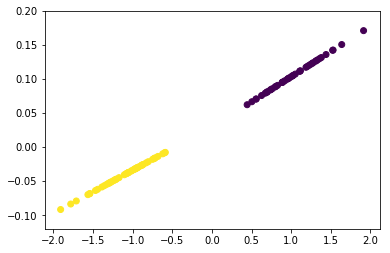

In [77]:
for epoch in range(n_epoch):
    avg_loss = 0.0
    pbar = Progbar(n_iter_per_epoch)
    for t in range(1, n_iter_per_epoch + 1):
        pbar.update(t)
        x_train = X_train[np.random.choice(np.arange(X_train.shape[0]), size=M)].astype(np.float32)
        info_dict = inference.update(feed_dict={x_ph: x_train})
        avg_loss += info_dict['loss']

    # Print a lower bound to the average marginal likelihood for an
    # image.
    clear_output()
    avg_loss = avg_loss / n_iter_per_epoch
    avg_loss = avg_loss / M
    print("log p(x) >= {:0.3f}".format(avg_loss))

    # show separation on a validation set
    n = np.random.randint(0, 10)
    latent_test_pred  = sess.run(location_param , feed_dict={x_ph:X_test[n*100:(n+1)*100]})
    plt.scatter(latent_test_pred[:, 0], latent_test_pred[:, 1], c=c_test[n*100:(n+1)*100])
    plt.show()

## GMM Prior

## Write the GMM Gaussian VAE model in edward

In [78]:
M = 100  # batch size during training

K = 2
n_hidden = 10
STD = 0.001 # initialization STD for neural weights

#positive_map = tf.nn.softplus
positive_map = tf.exp

In [79]:
def generative_network_z(input_y):
    """Generative network to parameterize generative model. It takes
    latent variables as input and outputs the likelihood parameters.

    location_x, scale_x, location_z, scale_z  = neural_network(input_z, input_y)

    """
    
    h_z = slim.fully_connected(input_y, n_hidden, 
                               activation_fn=tf.nn.relu, weights_initializer=tf.truncated_normal_initializer(stddev=STD))
    h_z = slim.fully_connected(h_z, 2*n_latent, 
                                  activation_fn=None, weights_initializer=tf.truncated_normal_initializer(stddev=STD))
    location_z = h_z[:, :n_latent]
    scale_z = positive_map(h_z[:, n_latent:])    
    
    return location_z, scale_z


def generative_network_x(input_z):  

    h_x = slim.fully_connected(input_z, n_hidden, 
                               activation_fn=tf.nn.relu, weights_initializer=tf.truncated_normal_initializer(stddev=STD))
    h_x = slim.fully_connected(h_x, 2*n_input, 
                                  activation_fn=None, weights_initializer=tf.truncated_normal_initializer(stddev=STD))
    location_x = h_x[:, :n_input]
    scale_x = positive_map(h_x[:, n_input:])
    
    return location_x, scale_x

def inference_network(input_x):
    """Inference network to parameterize variational model. It takes
    data as input and outputs the variational parameters.

    loc, scale = neural_network(input_x)
    
    """
    qh_y = slim.fully_connected(input_x, n_hidden, 
                               activation_fn=tf.nn.relu, weights_initializer=tf.truncated_normal_initializer(stddev=STD))
    qh_y = slim.fully_connected(qh_y, K, 
                                  activation_fn=None, weights_initializer=tf.truncated_normal_initializer(stddev=STD))
    qlogits_y = qh_y
    
    
    qh_z = slim.fully_connected(input_x, n_hidden, 
                               activation_fn=tf.nn.relu, weights_initializer=tf.truncated_normal_initializer(stddev=STD))
    qh_z = slim.fully_connected(qh_z, 2*n_latent, 
                                  activation_fn=None, weights_initializer=tf.truncated_normal_initializer(stddev=STD))
    qlocation_z = qh_z[:, :n_latent]
    qscale_z = positive_map(qh_z[:, n_latent:])
    
    return qlogits_y, qlocation_z, qscale_z

In [80]:
# MODEL
y = Categorical(logits=tf.ones([M, K]))
mu_z, sigma_z = generative_network_z(tf.expand_dims(tf.cast(y, tf.float32), 1))
z = Normal(loc=mu_z, scale=sigma_z)
location, scale = generative_network_x(z)
x = Normal(loc=location, scale=scale)

# INFERENCE
x_ph = tf.placeholder(tf.float32, [M, n_input])
qlogits_y, qlocation_z, qscale_z = inference_network(x_ph)
var_z = Normal(loc=qlocation_z, scale=qscale_z)
var_y = Categorical(logits=qlogits_y)

In [107]:
# Bind p(x, z) and q(z | x) to the same TensorFlow placeholder for x.
inference = ed.KLqp({z: var_z, y:var_y}, data={x: x_ph})
optimizer = tf.train.RMSPropOptimizer(0.001, epsilon=1.0)
#optimizer = tf.train.AdamOptimizer(0.01, epsilon=1.0)
inference.initialize(optimizer=optimizer)

tf.global_variables_initializer().run()

In [108]:
n_epoch = 3
n_iter_per_epoch = 1000

log p(x) >= 113.813


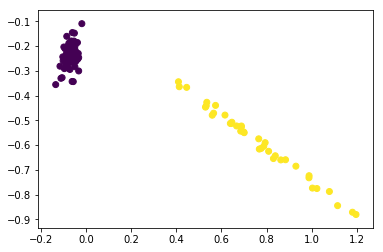

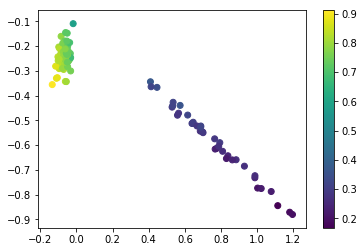

In [110]:
for epoch in range(n_epoch):
    avg_loss = 0.0
    pbar = Progbar(n_iter_per_epoch)
    for t in range(1, n_iter_per_epoch + 1):
        pbar.update(t)
        x_train = X_train[np.random.choice(np.arange(X_train.shape[0]), size=M)].astype(np.float32)
        info_dict = inference.update(feed_dict={x_ph: x_train})
        avg_loss += info_dict['loss']

    # Print a lower bound to the average marginal likelihood for an
    # image.
    clear_output()
    avg_loss = avg_loss / n_iter_per_epoch
    avg_loss = avg_loss / M
    print("log p(x) >= {:0.3f}".format(avg_loss))
    
    # show separation on a validation set
    n = np.random.randint(0, 10)
    logits_y, location_z  = sess.run((qlogits_y, qlocation_z) , feed_dict={x_ph:X_test[n*100:(n+1)*100]})
    plt.scatter(location_z[:, 0], location_z[:, 1], c=c_test[n*100:(n+1)*100])
    plt.show()
    c = np.exp(logits_y) / np.sum(np.exp(logits_y), axis=1)[:, np.newaxis]
    plt.scatter(location_z[:, 0], location_z[:, 1], c=c[:, 0])
    plt.colorbar()
    plt.show()
    
    